In [30]:
import urllib.parse
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


The Stockholm International Peace Research Institute (SIPRI) is a globally recognized research organization dedicated to studying conflict, armaments, arms control, and disarmament. Founded in 1966, SIPRI provides comprehensive, reliable, and timely information to policymakers, researchers, and the general public, with the aim of contributing to the understanding and resolution of armed conflict and promoting international peace and security.

One of SIPRI's key initiatives is its extensive database on international arms transfers, known as the SIPRI Arms Transfers Database. This database is a crucial resource for analyzing global trends in the transfer of major conventional weapons. It provides detailed, publicly accessible data on all international transfers of major conventional weapons, allowing for transparency and informed policy decisions.

SIPRI collects and analyzes data from various sources and analyzes it, tying transfers together from defense white papers, public finance statistics, as well as various UN bodies. Additionally, SIPRI utilizes data from NATO, the International Monetary Fund (IMF), and numerous specialized journals and newspapers to ensure comprehensive coverage of international arms transfers.

In terms of data preparation and cleaning, this data is already remarkably clean and will only be required to be read in to a graph database. We are going to extract out Recipient, Supplier as well as Armament Category to serve as the foundation of our analysis. 


Lets Prepare the data:

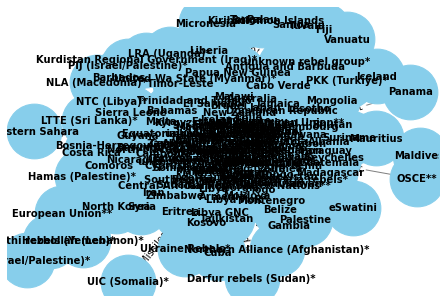

In [2]:
file_path = 'weapons_transfers.csv'  #Local path
df = pd.read_csv(file_path)

#Basic graph creation
G = nx.Graph()
for index, row in df.iterrows():
    supplier = row['Supplier']
    recipient = row['Recipient']
    armament_category = row['Armament category']
    
    G.add_node(supplier, type='supplier')
    G.add_node(recipient, type='recipient')
    

    G.add_edge(supplier, recipient, armament_category=armament_category)

#Simple fast dirty visualisation
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', edge_color='grey')
edge_labels = nx.get_edge_attributes(G, 'armament_category')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

Okay this data is too dense to cleanly display, lets try and pear it down to something more manageable. Were going to select the top 50 nodes and look at the interactions between them

In [9]:
top_50_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
top_50_nodes = [node for node, degree in top_50_nodes]
subgraph = G.subgraph(top_50_nodes) #I'm trimming down the data because I am not patient to wait


Now that we have the top 50 of each, lets get the discrete set of linkages between the top 50 nation states


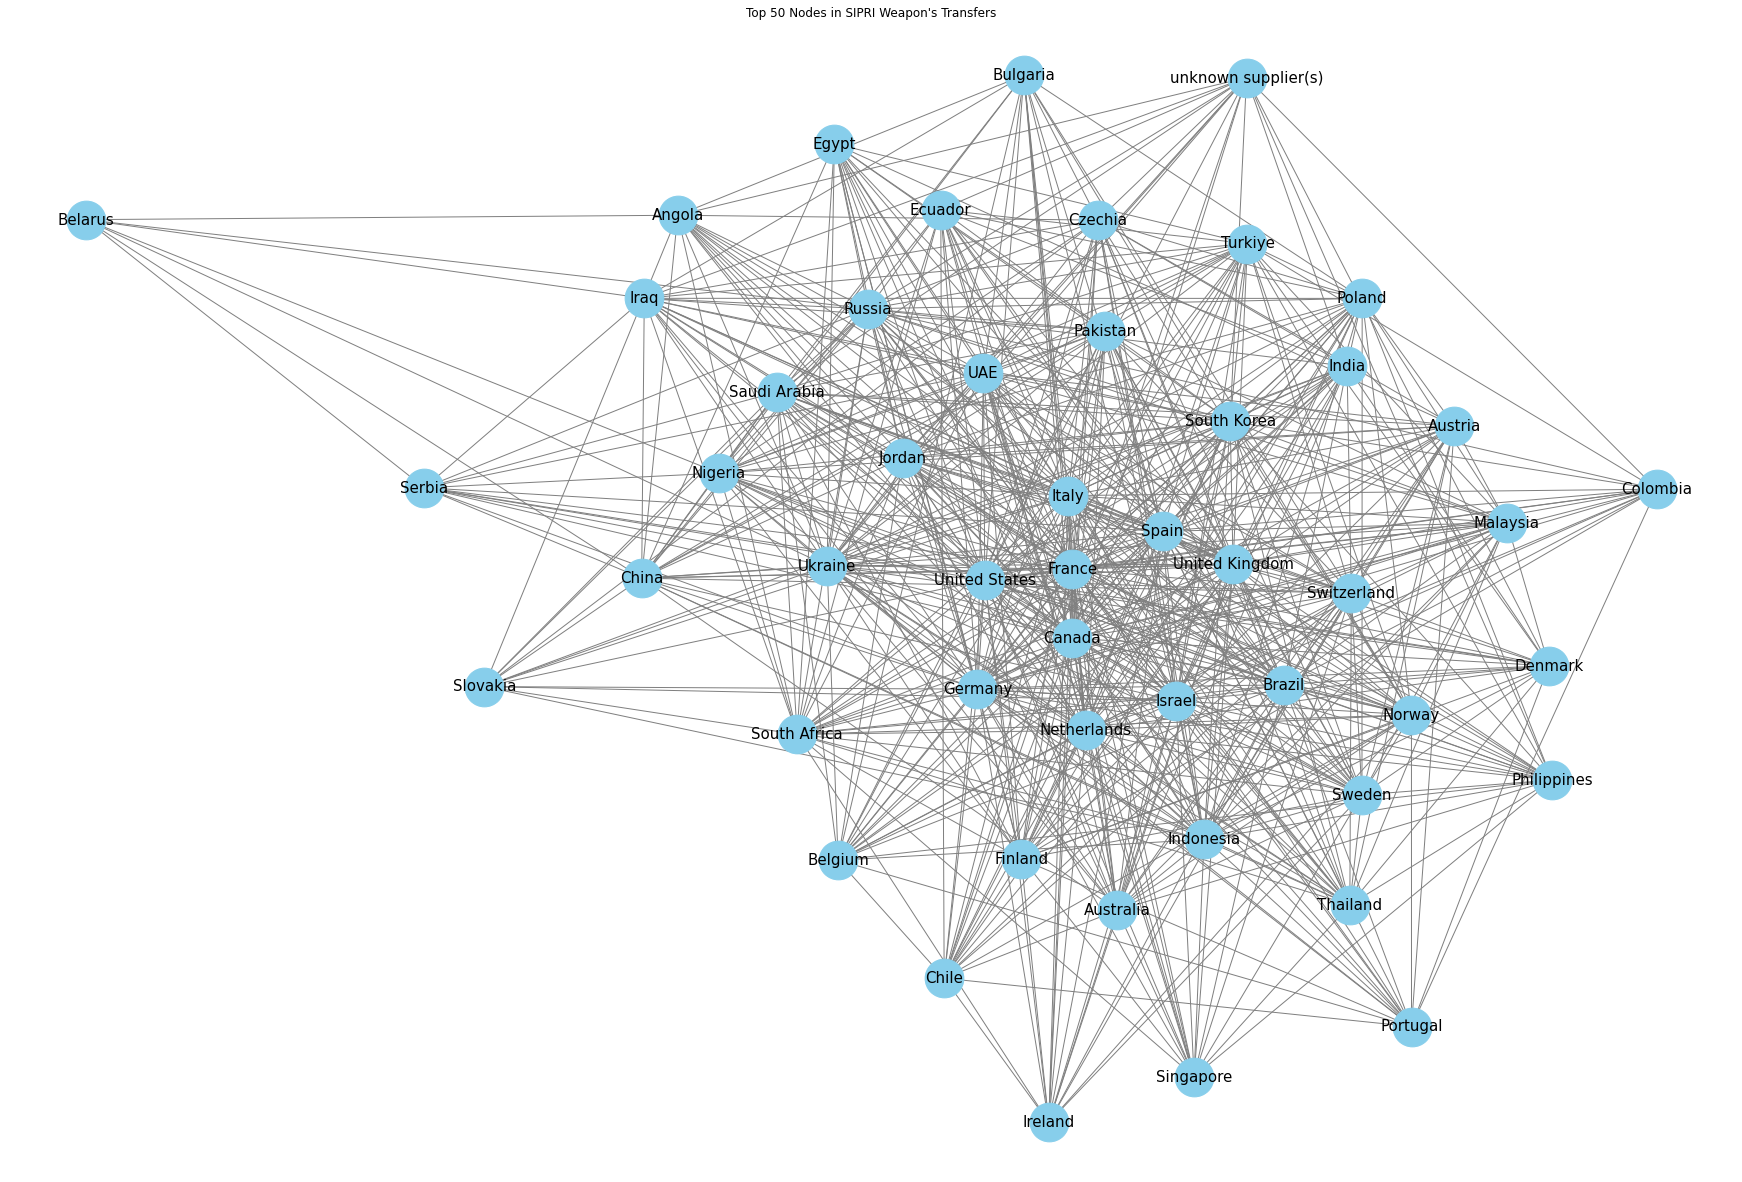

In [17]:
#Create a subgraph
subgraph = G.subgraph(top_50_nodes) #I'm trimming down the data so my laptop can handle this
plt.figure(figsize=(24, 16))
pos = nx.spring_layout(subgraph, k=0.1)  
nx.draw(subgraph, pos, node_size=1500, node_color='skyblue', edge_color='gray', with_labels=True, font_size=15, arrowsize=15)
plt.title("Top 50 Nodes in SIPRI Weapon's Transfers")
plt.show()

At this point, lets get the distinct armament categories:

In [43]:
armament_categories = set(nx.get_edge_attributes(subgraph, 'armament_category').values())
print("There are "+str(len(armament_categories))+" categories")
armament_categories

There are 11 categories


{'Air defence systems',
 'Aircraft',
 'Armoured vehicles',
 'Artillery',
 'Engines',
 'Missiles',
 'Naval weapons',
 'Other',
 'Satellites',
 'Sensors',
 'Ships'}

Lets calculate the various centrality measures:

We're first going to calculate the degree centrality

Essentially were going to calculate the eigenvector centrality measure for each of the distinct armament categories.
We will filter thorough each of the armament categories, then store the resultant centrality measure in a data structure. From there, we will then convert that data structure to a dataframe so that we can easily chart it.  

In [19]:
centrality_measures = []
for category in armament_categories:
    #Filter edges based on the specific armament category
    filtered_edges = [(u, v) for u, v, d in subgraph.edges(data=True) if d.get('armament_category') == category]
    
    #Create a new subgraph with only the armament category
    filtered_subgraph = nx.Graph()
    filtered_subgraph.add_edges_from(filtered_edges)
    
    for node in top_50_nodes:
        if node not in filtered_subgraph:
            filtered_subgraph.add_node(node)
    
    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(filtered_subgraph)
    
    for node, centrality in degree_centrality.items():
        centrality_measures.append({'Node': node, 'Armament Category': category, 'Degree Centrality': centrality})

# Convert the list to a DataFrame
centrality_df = pd.DataFrame(centrality_measures)
centrality_df

,Node,Armament Category,Degree Centrality
0,Malaysia,Ships,0.061224
1,China,Ships,0.061224
2,South Korea,Ships,0.142857
3,Spain,Ships,0.081633
4,Norway,Ships,0.040816
...,...,...,...
545,Belgium,Missiles,0.000000
546,Nigeria,Missiles,0.000000
547,Singapore,Missiles,0.000000
548,Ecuador,Missiles,0.000000


Essentially were going to calculate the eigenvector centrality measure for each of the distinct armament categories.
We will filter thorough each of the armament categories, then store the resultant centrality measure in a data structure. From there,
we will then convert that data structure to a dataframe so that we can easily chart it.  

In [25]:
#List to store centrality measures
eigenvector_centrality_measures = []

for category in armament_categories:
    #Filter edges based on the specific armament category
    filtered_edges = [(u, v) for u, v, d in subgraph.edges(data=True) if d.get('armament_category') == category]
    
    #Create a new subgraph with only armament category
    filtered_subgraph = nx.Graph()
    filtered_subgraph.add_edges_from(filtered_edges)
    
    #Add nodes to the filtered subgraph (to ensure all nodes from the original subgraph are included)
    for node in top_50_nodes:
        if node not in filtered_subgraph:
            filtered_subgraph.add_node(node)
    
    #Calculate eigenvector centrality
    try:
        eigenvector_centrality = nx.eigenvector_centrality(filtered_subgraph)
    except nx.PowerIterationFailedConvergence:
        # If the eigenvector centrality calculation fails to converge, set centrality to 0
        eigenvector_centrality = {node: 0 for node in filtered_subgraph.nodes()}

    for node, centrality in eigenvector_centrality.items():
        eigenvector_centrality_measures.append({'Node': node, 'Armament Category': category, 'Eigenvector Centrality': centrality})

#Convert the list to a DataFrame
eigenvector_centrality_df = pd.DataFrame(eigenvector_centrality_measures)

eigenvector_centrality_df = eigenvector_centrality_df.sort_values(by=['Armament Category', 'Eigenvector Centrality'], ascending=[True, False])
eigenvector_centrality_df

,Node,Armament Category,Eigenvector Centrality
151,Ukraine,Air defence systems,4.642061e-01
155,Norway,Air defence systems,4.274551e-01
160,Indonesia,Air defence systems,3.875995e-01
162,Switzerland,Air defence systems,3.449086e-01
158,United Kingdom,Air defence systems,3.048284e-01
...,...,...,...
45,Finland,Ships,2.728960e-25
46,Saudi Arabia,Ships,2.728960e-25
47,Serbia,Ships,2.728960e-25
48,Belarus,Ships,2.728960e-25


Let's take a peek at the top nodes per category for the Eigenvector Centrality. Its rather fascinating to see that Indonesia is so high for air defense systems. 

In [33]:
top_nodes_per_category = eigenvector_centrality_df.groupby('Armament Category').apply(lambda x: x.nlargest(10, 'Eigenvector Centrality')).reset_index(drop=True)
top_nodes_per_category

,Node,Armament Category,Eigenvector Centrality
0,Ukraine,Air defence systems,0.464206
1,Norway,Air defence systems,0.427455
2,Indonesia,Air defence systems,0.387600
3,Switzerland,Air defence systems,0.344909
4,United Kingdom,Air defence systems,0.304828
...,...,...,...
105,Egypt,Ships,0.250460
106,United Kingdom,Ships,0.239181
107,Spain,Ships,0.226179
108,Malaysia,Ships,0.192535


Now lets plot the data to visualize the Eigenvector Centrality:

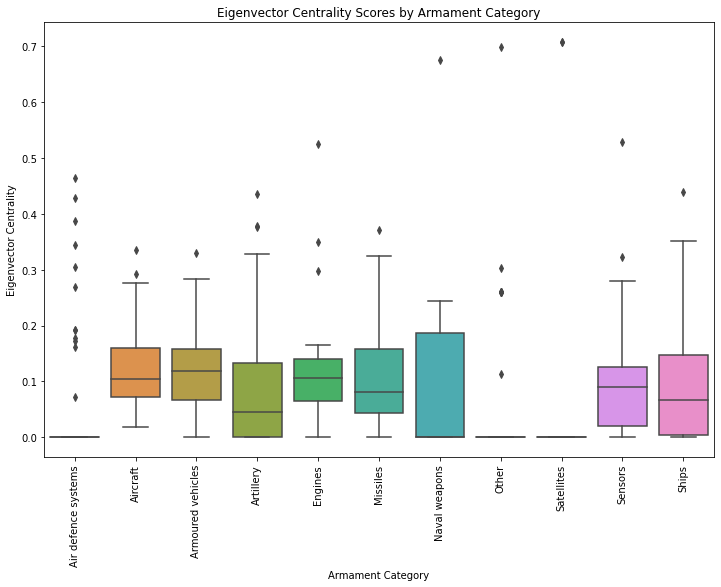

In [31]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=eigenvector_centrality_df, x='Armament Category', y='Eigenvector Centrality')
plt.title('Eigenvector Centrality Scores by Armament Category')
plt.xlabel('Armament Category')
plt.ylabel('Eigenvector Centrality')
plt.xticks(rotation=90)
plt.show()

Let's do the same with Degree Centrality

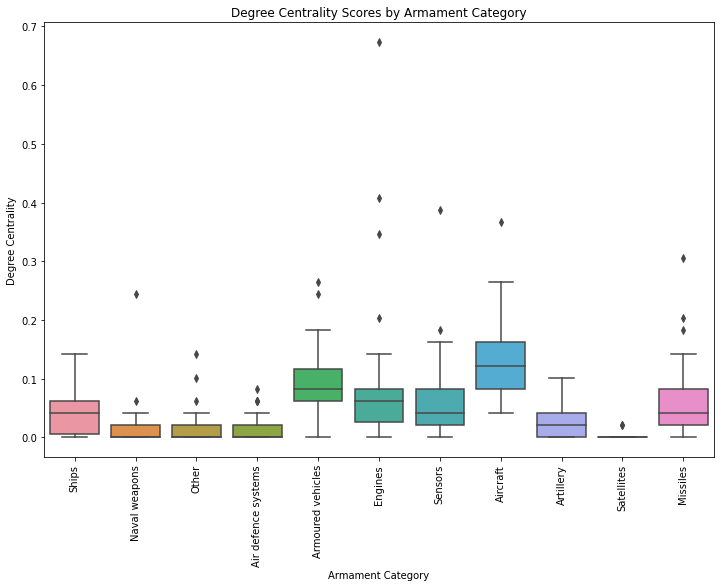

In [36]:
# Plot histograms of eigenvector centrality scores
plt.figure(figsize=(12, 8))
sns.boxplot(data=centrality_df, x='Armament Category', y='Degree Centrality')
plt.title('Degree Centrality Scores by Armament Category')
plt.xlabel('Armament Category')
plt.ylabel('Degree Centrality')
plt.xticks(rotation=90)
plt.show()

Let's add something fun to this, lets compare NATO vs non-Nato Countries:

In [45]:
nato_countries = [
    "Albania",
    "Belgium",
    "Bulgaria",
    "Canada",
    "Croatia",
    "Czechia",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Montenegro",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Türkiye",
    "United Kingdom",
    "United States"
]
eigenvector_centrality_df['NATO Country'] = eigenvector_centrality_df['Node'].apply(lambda x: x in nato_countries)
centrality_df['NATO Country'] = centrality_df['Node'].apply(lambda x: x in nato_countries)


,Node,Armament Category,Degree Centrality,NATO Country
0,Malaysia,Ships,0.061224,False
1,China,Ships,0.061224,False
2,South Korea,Ships,0.142857,False
3,Spain,Ships,0.081633,True
4,Norway,Ships,0.040816,True
...,...,...,...,...
545,Belgium,Missiles,0.000000,True
546,Nigeria,Missiles,0.000000,False
547,Singapore,Missiles,0.000000,False
548,Ecuador,Missiles,0.000000,False


Lets look at the Degree Centrality for NATO vs Non-Nato nations in the top 50 nodes:

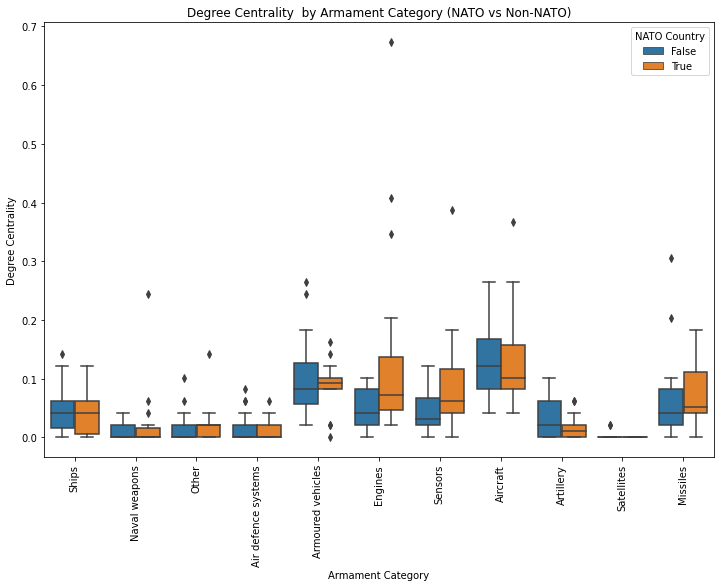

In [48]:
# Create the box plot for Degree Centrality with NATO vs Non-NATO
plt.figure(figsize=(12, 8))
sns.boxplot(data=centrality_df, x='Armament Category', y='Degree Centrality', hue='NATO Country')
plt.title('Degree Centrality  by Armament Category (NATO vs Non-NATO)')
plt.xlabel('Armament Category')
plt.ylabel('Degree Centrality')
plt.xticks(rotation=90)
plt.legend(title='NATO Country', loc='upper right')
plt.show()


Its rather fascinating that in terms of degree centrality, both NATO and non-NATO are remarkably similar in terms of trend. It seems as though there are a few number of nations that have a high degree of linkages and sales whereas the remainder do not have much at all. Another cool observation is that you can clearly see the speciality in Armoured Vehicles that Non-NATO nations have, whereas Nato Nations have a focus on both Sensors and Missiles. 

From here, lets look at the impact each node has on a network. 

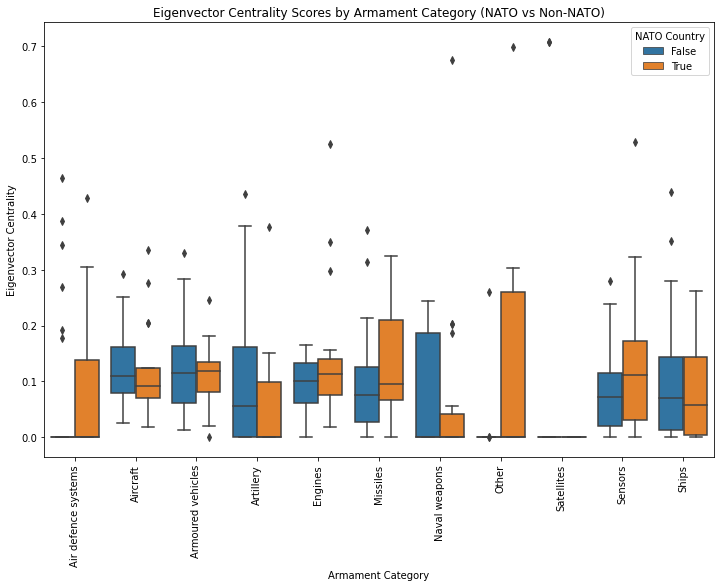

In [47]:
# Create the box plot for Eigenvector Centrality with NATO vs Non-NATO
plt.figure(figsize=(12, 8))
sns.boxplot(data=eigenvector_centrality_df, x='Armament Category', y='Eigenvector Centrality', hue='NATO Country')
plt.title('Eigenvector Centrality Scores by Armament Category (NATO vs Non-NATO)')
plt.xlabel('Armament Category')
plt.ylabel('Eigenvector Centrality')
plt.xticks(rotation=90)
plt.legend(title='NATO Country', loc='upper right')
plt.show()

Looking at the nodes above, we see a similar trend as we did in the chart above; Both Nato and Non-Nato share a lot of similarities. In terms of differences, Nato seems to have connections with higher impact in air defense systems, whereas Non-Nato has a higher degree of influence in Artillery as well as Armoured vehicles and naval weapons. 

I believe this analysis could be improved by adding in the TIV value in the data set. The TIV reflects the transfer of military resources by using the known unit production costs of a core set of weapons, rather than representing the financial value of the transfer. This would provide a much better way to represent the data, as currently the transfer of a battleship, or a simple harpoon have the same weight and linkage in this analysis. 

All in all, this is a high level look into the datasource and the nodes involved. I would love to delve more into this. 